In [25]:
%reload_ext autoreload
%autoreload 2
%run startup.py
from tqdm import tqdm


In [14]:
# Test boundary value reductions. 

v_0, v_1 = set_bv(500, j.v_max, j.a_max)
assert v_0==j.v_max and v_1==j.v_max

v_0, v_1 = set_bv(250, j.v_max, j.a_max)
assert v_0==j.v_max and v_1==0

v_0, v_1 = set_bv(250, 2500, j.a_max)
assert v_0==2500 and round(v_1) == 4330

v_0, v_1 = set_bv(100, 2500, j.a_max)
assert v_0==2500 and round(v_1) == 1936

b = j.new_block(100,2500, 5_000).init()
assert b.v_0==2500 and round(b.v_1) == 1936

b = j.new_block(10,2500, 5_000).init()
b.v_0,b.v_1
assert b.v_0==1000 and b.v_1 == 0


In [31]:
# Check differences between two was of calculating values. 
rows = []
for v_0, v_c, v_1 in tqdm(list(product(velocities,velocities, velocities))):
    x_ad, t_ad = accel_acd(v_0, v_c, v_1, a_max)
    
    x_a, t_a = accel_xt(v_0, v_c, a_max)
    x_d, t_d = accel_xt(v_c, v_1, a_max)
    
    rows.append( dict(x = x_ad - (x_a+x_d), t = t_ad -(t_a+t_d) ))
    
df = pd.DataFrame(rows)
                
df.describe()
    

100%|██████████| 13824/13824 [00:00<00:00, 387205.31it/s]


,x,t
count,1.382400e+04,1.382400e+04
mean,-4.584248e-16,-5.398423e-19
std,1.117347e-14,6.388327e-18
min,-5.684342e-14,-2.775558e-17
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00
max,1.136868e-13,2.775558e-17


<AxesSubplot:xlabel='x'>

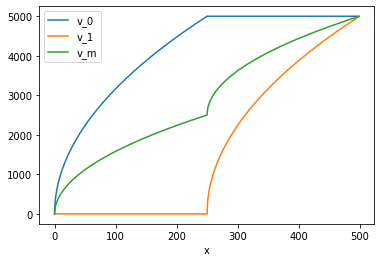

In [19]:
# Boundary Value reduction
j = Joint(5_000, 50_000)
rows = []
for x in range(500):
    v_0, v_1 = set_bv(x, v_max, a_max)
    rows.append(dict(x=x,v_0=v_0, v_1=v_1, v_m=(v_0+v_1)/2))

df = pd.DataFrame(rows)
df.set_index('x').plot()

In [20]:
# Test that values get passed through the Block sontructors. 
from trajectory.params import  Block, Joint

j = Joint(5_000, 50_000)
b = j.new_block(100,123,456)

assert b.x == 100, b.x
assert b.v_0 == 123
assert b.joint.v_max == 5_000

b = j.new_block(100,123,456)

assert b.x == 100
assert b.v_0 == 123
assert b.joint.v_max == 5_000


In [20]:
%reload_ext autoreload
%autoreload 2
%run startup.py
# Basic init and plan testing
#  - Initial planning
#  - Multiple updates to new time. 

j = Joint(5_000, 50_000)

n = 0
errors = []
rows = []
for i, (x, v_0, v_1) in tqdm(limits()): #choices(limits(),k=2_000):

    for _ in range(10):
        tf = random()*3+1.01 # Time factor, multiply with block time
        try:
            b = j.new_block(x, v_0, v_1).init()
            assert abs(b.area-b.x) < 1, (b, i)
            t = b.t*tf
            b.plan(t)
            assert abs(b.area - b.x)<3, (b.area, b, i, b.flag)
            if b.t != t:
                ot = b.t
                b.plan(ot)
                #assert round(b.t, 6) == round(ot, 6), (b.t, t)
                
            x_c, x_e = consistantize(b, True)
            a = b.area
        except:
            errors.append( (i, tf, b))
            raise
        d = dict(i=i, x=x, t=b.t, v_0=b.v_0, v_1=b.v_1, v_c=b.v_c, x_e = x_e, a=a, qc=b.flag)
        rows.append(d)
        
df = pd.DataFrame(rows)  
print('# rows =', len(df))
df.qc.value_counts(normalize=True)

100%|██████████| 11520/11520 [00:24<00:00, 468.27it/s]


# rows = 115200


O      0.868307
Z      0.050000
TZ1    0.047630
V0Z    0.020095
T0     0.010894
NT     0.002248
V1Z    0.000825
Name: qc, dtype: float64

In [17]:
df.sort_values('x_e', ascending=False)

,i,x,t,v_0,v_1,v_c,x_e,a,qc
105535,10553,2000,0.436821,1250.0,3750.0,4917.704256,0.000024,2000.000024,O
111306,11130,5000,1.047275,1250.0,4000.0,4910.123245,0.000024,5000.000024,O
109399,10939,2000,0.415265,5000.0,4250.0,4823.372984,0.000024,2000.000024,O
109501,10950,5000,1.114852,0.0,1000.0,4824.950952,0.000024,5000.000024,O
107079,10707,2000,0.458651,3000.0,250.0,4915.077508,0.000024,2000.000024,O
...,...,...,...,...,...,...,...,...,...
104427,10442,2000,0.510432,250.0,50.0,4746.473601,-0.000024,1999.999976,O
114207,11420,5000,1.042800,4250.0,4500.0,4798.522237,-0.000024,4999.999976,O
112244,11224,5000,1.030604,2250.0,3500.0,4942.017636,-0.000024,4999.999976,O
113898,11389,5000,1.034866,4000.0,2750.0,4883.045046,-0.000024,4999.999976,O


In [21]:
df.x_e.describe()

count    1.152000e+05
mean    -8.299891e-09
std      4.118102e-06
min     -2.396603e-05
25%     -1.300417e-06
50%      0.000000e+00
75%      1.256158e-06
max      2.456059e-05
Name: x_e, dtype: float64

In [10]:
r = df.iloc[41505]
b = j.new_block(r.x, r.v_0, r.v_1).init().plan(r.t)
print(b.area, b.x, b.area-b.x)
b.v_c += 1
print(b.area, b.x, b.area-b.x)


200.99999870338763 200 0.9999987033876323
207.16144815338762 200 7.161448153387624


In [22]:
%reload_ext autoreload
%autoreload 2
%run startup.py
# Basic init and plan testing
#  - Initial planning
#  - Multiple updates to new time. 
from tqdm import tqdm

j = Joint(5_000, 50_000)

n = 0
errors = []
rows = []
for i, (x, v_0, v_1) in tqdm(limits()): #choices(limits(),k=2_000):

    try:
        b = j.new_block(x, v_0, v_1).init()
        t = b.t
    
        for tf in np.linspace(1.01, 3, num=10):
            b.plan(t * tf)
            b.plan_ramp(t)
    except:
        errors.append( (i,  (x, v_0, v_1), tf) )
        raise
        

100%|██████████| 11520/11520 [00:24<00:00, 474.83it/s]


In [19]:
(i,  (x, v_0, v_1), tf) = errors[0]
print(i, x, v_0, v_1)
b = j.new_block(x, v_0, v_1).init()
b

5594 250 3750 50


Block(x=250, t=0.10078235206037961, t_a=0.0133911760301898, t_c=6.430892925487639e-18, t_d=0.0873911760301898, x_a=54.699999999999996, x_c=2.842170943040401e-14, x_d=195.29999999999998, v_0=3750, v_c=4419.55880150949, v_1=50, d=1, joint=Joint(v_max=5000, a_max=50000, small_x=500.0), flag='S', recalcs=0, next=None, prior=None)

In [ ]:
from copy import deepcopy

j = Joint(5_000, 50_000)

def make_segments():
    
    segments = []
    
    def _mkb(v_0, v_1):
        moves = [ (x, v_0, v_1) for i, (x, _, _) in choices(limits(),k=4) ]
        return [j.new_block(*args).init() for  args in moves]
    
    segments.append(_mkb(0, v_max))
    
    for i in range(2):
        segments.append(_mkb(v_max, v_max))
    
    segments.append(_mkb(v_max, 0))
    
    return segments

def plan_iter(blocks):
    
    sb = deepcopy(blocks) # save for later. 
    
    mt = max([ b.t for b in blocks])
    [b.plan(mt) for b in blocks]
    mt_new = max([ b.t for b in blocks])

    v_0_unchanged = all([ b1.v_0 == b2.v_0 for b1, b2 in zip(blocks, sb)])
    v_1_unchanged = all([ b1.v_1 == b2.v_1 for b1, b2 in zip(blocks, sb)])
    mt_unchanged = (mt_new == mt)
    
    a1 = [ round(b1.area) for b1 in blocks]
    a2 = [ round(b2.area) for b2 in sb]
    
    assert all([ a1 == a2 for a1, a2 in zip(a1, a2)])
    
    return  (v_0_unchanged and v_1_unchanged and mt_unchanged)
             
    
def plan_segment(blocks):    
    i = 0
    while True:
        if plan_iter(blocks):
            break
        i+=1
        assert i < 10
        
    return blocks
   

def forward_update_boundary(s1, s2):
    
    updates = 0
    for b1, b2 in zip(s1, s2):
        update = False
        if b1.v_1 != b2.v_0:
            v = min(b1.v_1, b2.v_0)
            b1.v_1 = v
            b2.v_0 = v
            updates +=1
            update = True
            

        #if abs(b1.v_c - b2.v_c) < 100:
        #    update = True
        #    b.v_0 = b.v_1 = (b1.v_c + b2.v_c)/2
            
            
        if update:
            b1.init()
            b2.init()
            
    return updates
    

#blocks = plan_segment()

#blocks = [ (b,) for b in blocks ]

segments = make_segments()


print([forward_update_boundary(s1, s2) for s1, s2 in zip(segments, segments[1:])])
[plan_segment(s) for s in segments]
print([forward_update_boundary(s1, s2) for s1, s2 in zip(segments, segments[1:])])
[plan_segment(s) for s in segments]


plot_params(*segments)


#print [ (b1.v_1, b2.v_0) for b1, b2 in zip(s1, s2[1:])]


AssertionError: (-1.0, 4995, 'S', Block(x=249, t=0.0997997997997998, t_a=0.0001, t_c=-0.0002002002002002002, t_d=0.0999, x_a=0.49975, x_c=-1.0, x_d=249.50025, v_0=5000, v_c=4995, v_1=0, v_0_max=None, v_0_min=0, v_1_max=None, v_1_min=0, t_min=0, d=1, joint=Joint(v_max=5000, a_max=50000, small_x=500.0), flag='S', recalcs=0, jsclass=None, next=None, prior=None))

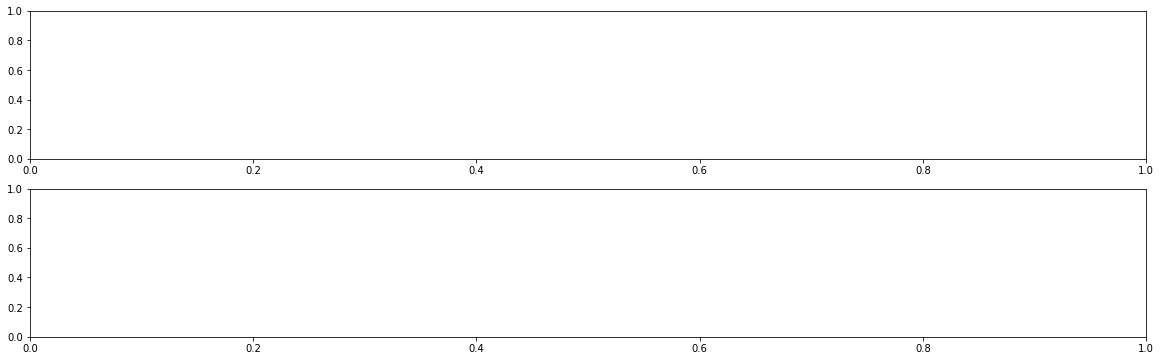

In [45]:
j = Joint(5_000, 50_000)

x = 249
v_0 = 5000
v_1 = 0

fig, ax = plt.subplots(2,1, figsize = (20, 6))
b = j.new_block(x, v_0, v_1).init()
end = .4
for t in np.linspace(b.t, end, num=4):
    b.plan_ramp(t)
    plot_params(b, ax=ax[0])

b = j.new_block(x, v_0, v_1).init()
for t in np.linspace(b.t, end, num=4):
    b.plan(t)
    plot_params(b, ax=ax[1])
    
    

In [ ]:
# Test simple updating between pairs of blocks

%reload_ext autoreload
%autoreload 2
%run startup.py

a_max = 50_000
v_max = 5_000

step = 1_000
velocities = list(range(0, v_max+step, step))

vp = list(product(velocities, velocities))
keys = 'v_0 v_1'.split()

#v_args_a =  [dict(zip(keys, v)) for v in vp]
v_args_a =  [dict(v_0=v[0], v_1=v_max) for v in vp]
v_args_b =  v_args_a[-1:] + v_args_a[:-1]
v_args_c =  v_args_a[1:]  + v_args_a[:1]

records= []

def ip(args_a, args_b, args_c):
    return [min_profile(randint(10,2000),**args_a, v_max=v_max, a_max = a_max) for _ in range(3)]


for i,(args_a, args_b, args_c) in enumerate(zip(v_args_a, v_args_b, v_args_c)):
    records.append(ip(args_a, args_b, args_c))
   
def update_pair(p,n,t):
    ag_mp = attrgetter(*'x v_0 v_1 v_max a_max'.split())

    v_0 = p.v_0
    v_1 = p.v_1
    p_t = p.t
     
    # Remake the profile
    # n = min_profile(*ag_mp(n.replace(v_0=p.v_1)))
    # expand the time
    
    n = update_params(n, max(t, n.t), v_0=p.v_1)
    
    for i in range(4):
        
        v_m = (p.v_1+n.v_0)/2
        p = min_profile(*ag_mp(p.replace(v_1=v_m)))
        n = min_profile(*ag_mp(n.replace(v_0=v_m)))

        n = update_params(n, max(t, n.t))
        p = update_params(p, p.t)
        
        if p.v_1 == n.v_0 and p.v_1 == v_m:
            break
        
    return i, p,n

counts = []
for i,r in enumerate(records):
    z, p,n = update_pair(r[0],r[1], r[1].t*1.5)
    counts.append(z)
    #plot_adj(p,n)

In [ ]:
from itertools import islice

def grouper(n, iterable):
    it = iter(iterable)
    while True:
        chunk = tuple(islice(it, n))
        if not chunk:
            return
        yield chunk
        
for g in islice(grouper(3, all_p), 10):
    mt = max([p.t for p in g])
    if mt == 0:
        continue
    
    print(mt)
    


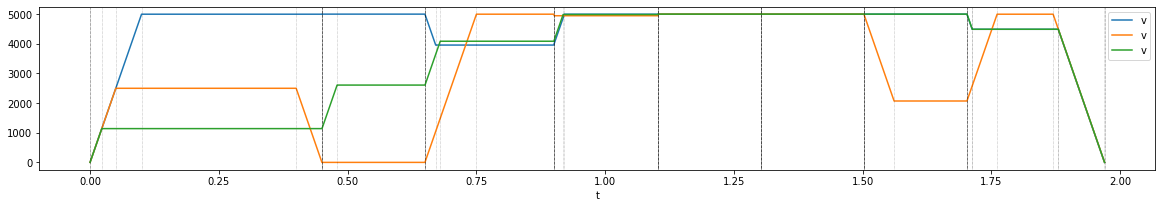

In [32]:
%reload_ext autoreload
%autoreload 2
%run startup.py

from trajectory.planner import Joint, SegmentList

j = Joint(5_000, 50_000)
joints = [j]*3

sl = SegmentList(joints)   
s = sl.rmove([2000,1000,500])
s = sl.rmove([1000,0,500])
s = sl.rmove([1000,1000,1000])
s = sl.rmove([1000,1000,1000])
s = sl.rmove([1000,1000,1000])
s = sl.rmove([1000,1000,1000])
s = sl.rmove([1000,500,1000])
s = sl.rmove([1000,1000,1000])


sl.plot()


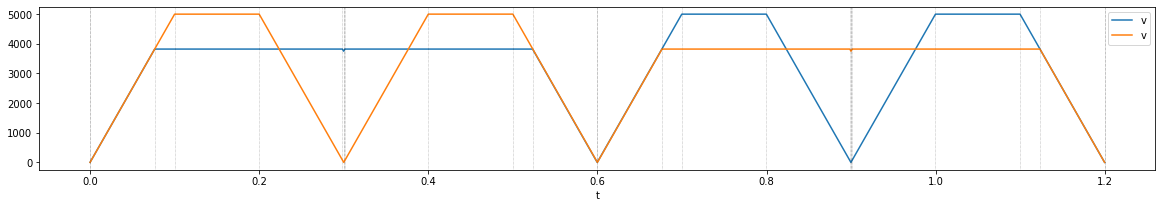

In [7]:
from trajectory.planner import Joint, SegmentList

j = Joint(5_000, 50_000)
joints = [j]*2

sl = SegmentList(joints)   
s = sl.rmove([1000,1000])
s = sl.rmove([1000,-1000])
s = sl.rmove([-1000,-1000])
s = sl.rmove([-1000,1000])


sl.plot()

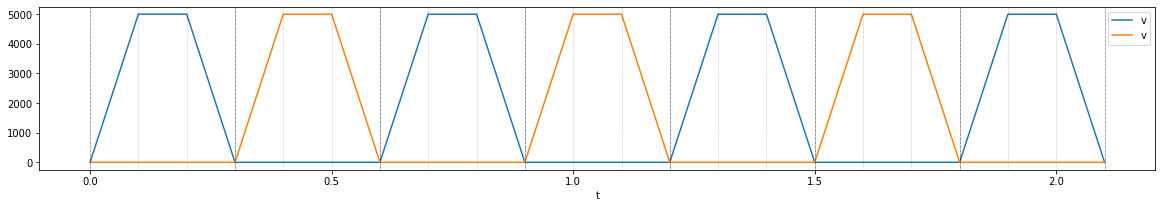

In [106]:
from trajectory.planner import Joint, SegmentList

j = Joint(5_000, 50_000)
joints = [j]*2

sl = SegmentList(joints)   
s = sl.rmove([1000,1])
s = sl.rmove([1,1000])
s = sl.rmove([1000,1])
s = sl.rmove([1,1000])
s = sl.rmove([1000,1])
s = sl.rmove([1,1000])
s = sl.rmove([1000,1])

sl.plot()


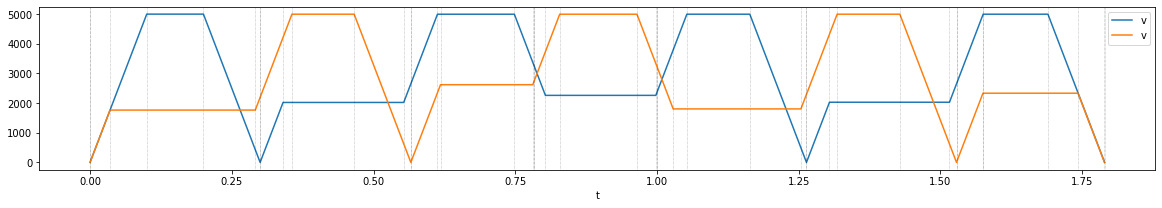

In [107]:
from trajectory.planner import Joint, SegmentList

j = Joint(5_000, 50_000)
joints = [j]*2

sl = SegmentList(joints)   
s = sl.rmove([1000,500])
s = sl.rmove([-500,1000])
s = sl.rmove([1000,-500])
s = sl.rmove([500,1000])
s = sl.rmove([1000,500])
s = sl.rmove([-500,1000])
s = sl.rmove([1000,-500])

sl.plot()